<a href="https://colab.research.google.com/github/redwaneaitouammi/Data_Science_Recommendation_System_Sotify_Dataset/blob/main/Project6_Data_Science_Recommendation_System_Sotify_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Spotify Dataset, 1921 - 2020, 160k+ Tracks**


Community Data License Agreement – Sharing – Version 1.0 
Data from Kaggle, The "data.csv" file contains more than 175.000 songs collected from Spotify Web API

Primary:
- id (Id of track generated by Spotify)
Numerical:
- acousticness (Ranges from 0 to 1)
- danceability (Ranges from 0 to 1)
- energy (Ranges from 0 to 1)
- duration_ms (Integer typically ranging from 200k to 300k)
- instrumentalness (Ranges from 0 to 1)
- valence (Ranges from 0 to 1)
- popularity (Ranges from 0 to 100)
- tempo (Float typically ranging from 50 to 150)
- liveness (Ranges from 0 to 1)
- loudness (Float typically ranging from -60 to 0)
- speechiness (Ranges from 0 to 1)
- year (Ranges from 1921 to 2020)
Dummy:
- mode (0 = Minor, 1 = Major)
- explicit (0 = No explicit content, 1 = Explicit content)
Categorical:
- key (All keys on octave encoded as values ranging from 0 to 11, starting on C as 0, C# as 1 and so on…)
- artists (List of artists mentioned)
- release_date (Date of release mostly in yyyy-mm-dd format, however precision of date may vary)
- name (Name of the song)

In [ ]:
import numpy as np 
np.set_printoptions(threshold=10000,suppress=True) 
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Data_Spotify/data.csv")

In [ ]:
print("Dimensions : ", data.shape)
data.head(3)

Dimensions :  (174389, 19)


,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.634,1920
1,0.643,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.950,1920
2,0.993,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.689,1920


#Explore data
Check the type of variables and the presence or absence of missing values:

In [ ]:
data_types = pd.DataFrame(data.dtypes, columns=["Types"])
data_types


,Types
acousticness,float64
artists,object
danceability,float64
duration_ms,int64
energy,float64
explicit,int64
id,object
instrumentalness,float64
key,int64
liveness,float64


In [ ]:
nan = pd.DataFrame(data.isna().any(),columns=["na"])
nan

,na
acousticness,False
artists,False
danceability,False
duration_ms,False
energy,False
explicit,False
id,False
instrumentalness,False
key,False
liveness,False


Retrieve the min and max of the numeric variables, to get an idea of the range of values:

In [ ]:
min= pd.DataFrame(data.drop(columns=["artists", "id", "name", "release_date"]).min(axis=0).round(decimals=1),columns=["max]"])
max= pd.DataFrame(data.drop(columns=["artists", "id", "name", "release_date"]).max(axis=0).round(decimals=1),columns=["[min"])
max,min

(                       [min
 acousticness            1.0
 danceability            1.0
 duration_ms       5338302.0
 energy                  1.0
 explicit                1.0
 instrumentalness        1.0
 key                    11.0
 liveness                1.0
 loudness                3.9
 mode                    1.0
 popularity            100.0
 speechiness             1.0
 tempo                 243.5
 valence                 1.0
 year                 2021.0,                     max]
 acousticness         0.0
 danceability         0.0
 duration_ms       4937.0
 energy               0.0
 explicit             0.0
 instrumentalness     0.0
 key                  0.0
 liveness             0.0
 loudness           -60.0
 mode                 0.0
 popularity           0.0
 speechiness          0.0
 tempo                0.0
 valence              0.0
 year              1920.0)

Summary

In [ ]:
tab = pd.merge(data_types,nan,left_index=True,right_index=True,how="outer")
tab = pd.merge(tab, max, left_index = True, right_index = True, how="outer")
tab = pd.merge(tab, min, left_index = True, right_index = True, how="outer")

tab

,Types,na,[min,max]
acousticness,float64,False,1.0,0.0
artists,object,False,NaN,NaN
danceability,float64,False,1.0,0.0
duration_ms,int64,False,5338302.0,4937.0
energy,float64,False,1.0,0.0
explicit,int64,False,1.0,0.0
id,object,False,NaN,NaN
instrumentalness,float64,False,1.0,0.0
key,int64,False,11.0,0.0
liveness,float64,False,1.0,0.0


The month of release of the title could have an influence on its popularity (e.g. release during the summer). From the "release_date" variable we could therefore keep only this information when it is available (since there is already a column for the year of release):

In [ ]:
#Retrieve the month of release of the title when the information is available:
import re
result = []
reg_expr = re.compile(r"^\d+-\d+-\d+$")
for i in range(data.shape[0]) :
    find = re.search(reg_expr, data["release_date"][i])
    if find != None :
         value = data["release_date"][i].split("-")
         result.append(int(value[1]))
print(result[:20])

[1, 1, 10, 7, 1, 7, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
#Count the number of titles for which information is not available:
nb = data.shape[0]-len(result)
pc = 100 * nb/data.shape[0]
print("Month of release not known for", nb, "observations")
print("Therefore", "%.1f"%pc, "% of database")

Month of release not known for 52405 observations
Therefore 30.1 % of database


Since the number of titles for which the release month is not known -(almost 1/3 of the database) - I prefer to completely remove the "release_date" column.

In [ ]:
data.drop(columns="release_date", inplace = True)

Let's look at some descriptive statistics about the variables:

In [ ]:
data.describe().round(decimals=2)

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00
mean,0.50,0.54,232810.03,0.48,0.07,0.20,5.21,0.21,-11.75,0.70,25.69,0.11,117.01,0.52,1977.06
std,0.38,0.18,148395.80,0.27,0.25,0.33,3.52,0.18,5.69,0.46,21.87,0.18,30.25,0.26,26.91
min,0.00,0.00,4937.00,0.00,0.00,0.00,0.00,0.00,-60.00,0.00,0.00,0.00,0.00,0.00,1920.00
25%,0.09,0.41,166133.00,0.25,0.00,0.00,2.00,0.10,-14.91,0.00,1.00,0.04,93.93,0.31,1955.00
50%,0.52,0.55,205787.00,0.46,0.00,0.00,5.00,0.14,-10.84,1.00,25.00,0.05,115.82,0.54,1977.00
75%,0.90,0.67,265720.00,0.71,0.00,0.25,8.00,0.27,-7.50,1.00,42.00,0.08,135.01,0.74,1999.00
max,1.00,0.99,5338302.00,1.00,1.00,1.00,11.00,1.00,3.86,1.00,100.00,0.97,243.51,1.00,2021.00


The numbers may not be very meaningful. Let's do some dataviz now !

Quantitative variables

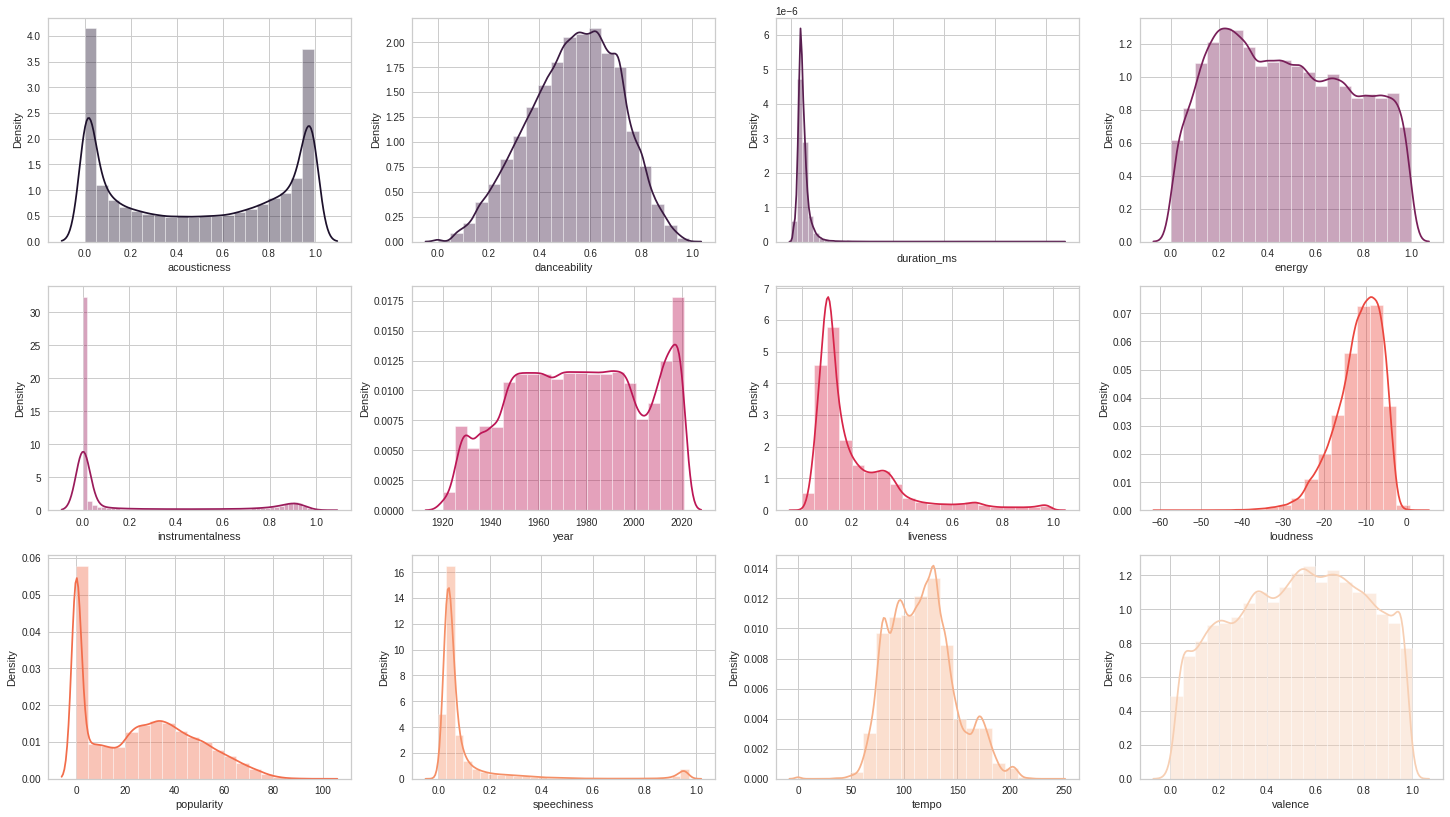

In [ ]:
#Histogrammes
f, axarr = plt.subplots(3,4, figsize=(25,14))
palette = sns.color_palette("rocket", 12)
sns.distplot(data["acousticness"],  bins=20, ax = axarr[0][0], hist_kws=dict(edgecolor="white", linewidth=1), color = palette[0])
sns.distplot(data["danceability"],  bins=20, ax = axarr[0][1], hist_kws=dict(edgecolor="white", linewidth=1), color = palette[1])
sns.distplot(data["duration_ms"],  bins=50, ax = axarr[0][2], hist_kws=dict(edgecolor="white", linewidth=1), color = palette[2])
axarr[0][2].set_xticklabels([])
sns.distplot(data["energy"],  bins=20, ax = axarr[0][3], hist_kws=dict(edgecolor="white", linewidth=1), color = palette[3])
sns.distplot(data["instrumentalness"],  bins=50, ax = axarr[1][0], hist_kws=dict(edgecolor="white", linewidth=1), color = palette[4])
sns.distplot(data["year"],  bins=20, ax = axarr[1][1], hist_kws=dict(edgecolor="white", linewidth=1), color = palette[5])
sns.distplot(data["liveness"],  bins=20, ax = axarr[1][2], hist_kws=dict(edgecolor="white", linewidth=1), color = palette[6])
sns.distplot(data["loudness"],  bins=20, ax = axarr[1][3], hist_kws=dict(edgecolor="white", linewidth=1), color = palette[7])
sns.distplot(data["popularity"], ax = axarr[2][0], bins=20, hist_kws=dict(edgecolor="white", linewidth=1), color = palette[8])
sns.distplot(data["speechiness"],  bins=30, ax = axarr[2][1], hist_kws=dict(edgecolor="white", linewidth=1), color = palette[9])
sns.distplot(data["tempo"],  bins=20, ax = axarr[2][2], hist_kws=dict(edgecolor="white", linewidth=1), color = palette[10])
sns.distplot(data["valence"],  bins=20, ax = axarr[2][3], hist_kws=dict(edgecolor="white", linewidth=1), color = palette[11])

Categorical variables

Text(0.5, 1.0, 'Presence of explicit content (lyrics) or not (0 or 1)')

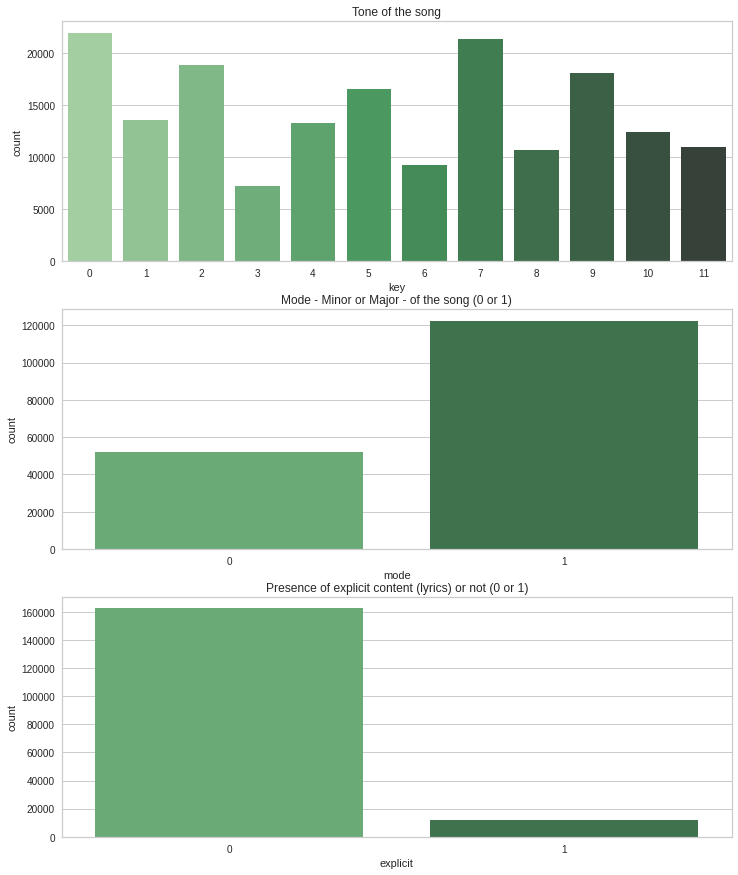

In [ ]:
#Countplots
f, axes = plt.subplots(3,1, figsize=(12,15))
sns.countplot(x="key", data=data, ax = axes[0], palette="Greens_d")
axes[0].set_title("Tone of the song")
sns.countplot(x="mode", data=data, ax = axes[1], palette="Greens_d")
axes[1].set_title("Mode - Minor or Major - of the song (0 or 1)")
sns.countplot(x="explicit", data=data, ax = axes[2], palette="Greens_d")
axes[2].set_title("Presence of explicit content (lyrics) or not (0 or 1)")

 Finding correlations

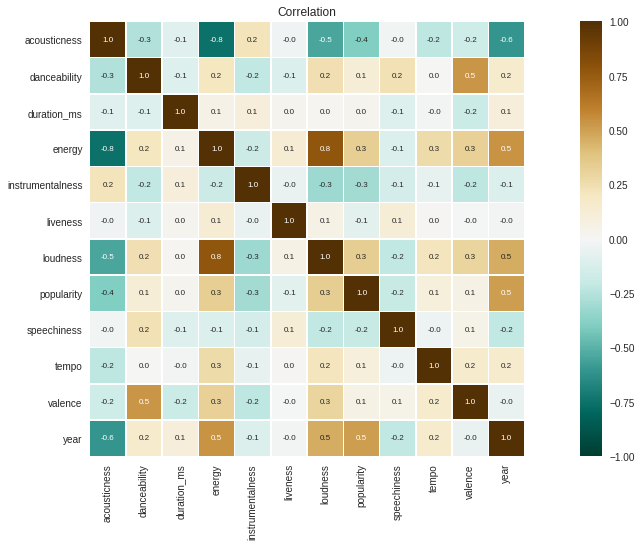

In [ ]:
data["key"] = data["key"].astype("int").astype("category")
data["mode"] = data["mode"].astype("int").astype("category")
data["explicit"] = data["explicit"].astype("int").astype("category")
corr = data.corr()
#Viz
plt.figure(figsize=(20,8))
sns.heatmap(corr, vmax=1, vmin=-1, center=0,linewidth=.5,square=True, annot = True, annot_kws = {'size':8},fmt='.1f', cmap='BrBG_r')
plt.title('Correlation')
plt.show()

 Statistics and Preliminary Analysis

In [ ]:
data['artists'] = data['artists'].apply(lambda x: x[1:-1].split(', '))
# Each artist will have his own line for a given song:
data_bis = data.explode('artists')


In [ ]:
# Remove quotation marks :
data_bis['artists'] = data_bis['artists'].apply(lambda x: x.strip("'"))

In [ ]:
data_bis['artists'].value_counts()

Francisco Canaro            2228
Tadeusz Dolega Mostowicz    1281
Эрнест Хемингуэй            1175
Эрих Мария Ремарк           1062
Frédéric Chopin             1013
                            ... 
James Whitmore                 1
Ten Nararak                    1
Seo Fernandez                  1
DAVI                           1
Tedi Papavrami                 1
Name: artists, Length: 32660, dtype: int64

Let's see the Top10 artists who produce more content than others

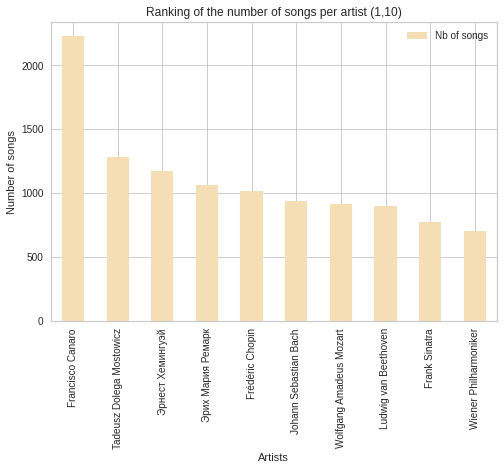

In [ ]:
Top10 = pd.DataFrame({'Nb of songs':data_bis['artists'].value_counts().head(10)})
Top10.plot.bar(color='wheat')
plt.title(f'Ranking of the number of songs per artist (1,10)')
plt.xlabel('Artists')
plt.ylabel('Number of songs')
plt.show()

Top 10 Artists by popularity

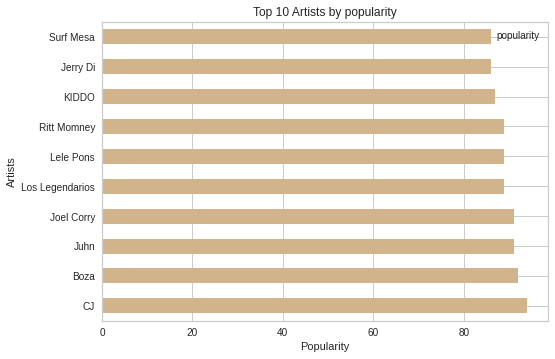

In [ ]:
artists_grp = data_bis.groupby(['artists'])
Top10_by_pop = artists_grp[['popularity']].mean().sort_values(by=['popularity'],ascending=False)[:10]
Top10_by_pop.plot.barh(color='tan')
plt.title('Top 10 Artists by popularity')
plt.xlabel('Popularity')
plt.ylabel('Artists')
plt.show()

Trends of songs over time

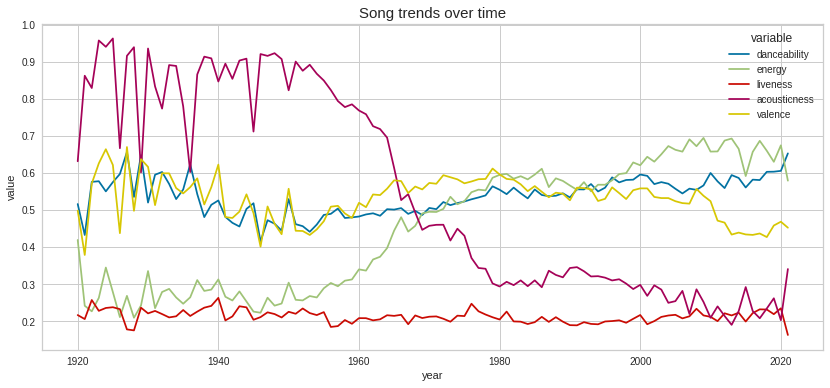

In [ ]:
year_avg = data[['danceability','energy','liveness','acousticness', 'valence','year']].groupby('year').mean().sort_values(by='year').reset_index()
#Convert the year_avg dataframe to a 3-column database (year,variable(5 features), value)
melted = year_avg.melt(id_vars='year') #merger
plt.figure(figsize=(14,6))
plt.title("Song trends over time", fontsize=15)
sns.lineplot(x='year',y='value',hue='variable',data=melted) #hue: add several curves instead of a loop

Recommendation System: Naive Approach by Popularity

A simple idea could be to recommend the most popular titles. After all, the most listened-to titles, which are liked by the greatest number of people, will have a higher probability of being appreciated by the average audience.

In [ ]:
selected_titles = data.sort_values(by='popularity', ascending=False).iloc[0:10,:]

However, the limitations of this model are obvious: it is not exactly what we would call a personalised recommendation, the aim being to propose titles to the user taking into consideration his specific interests. So let's go further in the process.

Recommendation System: Content-Based Approach

Clustering with kmeans

In [ ]:
num_features = ['acousticness','danceability','energy',"duration_ms",'instrumentalness','valence','popularity','tempo','loudness','liveness','speechiness'] 
bin_features = ['mode','explicit','key']
spotify_num = data[num_features]

Normalization of numerical variables

In [ ]:
sc = StandardScaler()
sc.fit(spotify_num)
spotify_num_norm = sc.transform(spotify_num)
pd_spotify_num_norm = pd.DataFrame(spotify_num_norm, columns=num_features)
pd_spotify_num_norm.head()
print(spotify_num_norm)

[[ 1.29435782  0.34791933 -0.94879121 ... -0.15411114  0.93010589
  -0.06654892]
 [ 0.37841108  1.79089823  0.12570987 ...  0.78886167 -0.72148905
  -0.28711336]
 [ 1.29962188  0.62628927 -1.08814629 ... -0.06099103  1.70576269
   0.37457996]
 ...
 [ 0.80743211  0.76263374  0.38975108 ... -0.11282203 -0.54364203
  -0.42537764]
 [ 1.10748363 -0.4246993  -0.89011538 ... -0.05730137 -0.54364203
  -0.3732542 ]
 [-0.6849294   0.79671985 -0.08332277 ... -0.0854131   0.02147935
  -0.43854567]]


Categorical variable encoding 'key'

In [ ]:
spotify_bin = OneHotEncoder().fit_transform(data[['key']]).toarray()
print(spotify_bin)
spotify_bin.shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(174389, 12)

Concatenation of transformed categorical data and normalized continuous data

In [ ]:
spotify_norm = np.concatenate((spotify_num_norm,data[['mode','explicit','key']].to_numpy(),spotify_bin, data[['artists','name','id']]), axis=1)
spotify_norm.shape

(174389, 29)

In [ ]:
colname = ['acousticness','danceability','energy',"duration_ms",'instrumentalness','valence','popularity','tempo','loudness','liveness','speechiness','mode','explicit','key','key0','key1','key2','key3','key4','key5','key6','key7','key8','key9','key10','key11','artist','name','id'] 
spotify_norm= pd.DataFrame(spotify_norm,columns=colname)
spotify_norm.head(0)

,acousticness,danceability,energy,duration_ms,instrumentalness,valence,popularity,tempo,loudness,liveness,speechiness,mode,explicit,key,key0,key1,key2,key3,key4,key5,key6,key7,key8,key9,key10,key11,artist,name,id


In [ ]:
spotify_train = spotify_norm.iloc[:, 0:13]
spotify_train.head(3)

,acousticness,danceability,energy,duration_ms,instrumentalness,valence,popularity,tempo,loudness,liveness,speechiness,mode,explicit
0,1.29436,0.347919,-0.948791,-0.434495,-0.588004,0.413903,-0.62605,1.08975,-0.154111,0.930106,-0.0665489,0,0
1,0.378411,1.7909,0.12571,-0.556689,-0.510657,1.60872,-0.854645,-0.995485,0.788862,-0.721489,-0.287113,0,0
2,1.29962,0.626289,-1.08815,-0.46486,-0.589511,0.621861,-0.991803,-0.64145,-0.060991,1.70576,0.37458,1,0


Principal component analysis

In [ ]:
def acp_reduction(data_scaled,n_components):
  acp = PCA(n_components=n_components,random_state=42)
  pcomp = acp.fit_transform(data_scaled)
  acp_data = pd.DataFrame(data = pcomp, columns=['PC1','PC2'])
  ratio = acp.explained_variance_ratio_
  composant = acp.components_
  return acp_data,ratio,composant 

In [ ]:
spotify_acp, ratio, composant = acp_reduction(spotify_train,2)

In [ ]:
def plot_acp(acp_data,hue):
  sns.scatterplot(x=acp_data['PC1'], y=acp_data['PC2'],hue=hue,palette="pastel")
  plt.xlabel('PC1')
  plt.ylabel('PC2')
  plt.show()

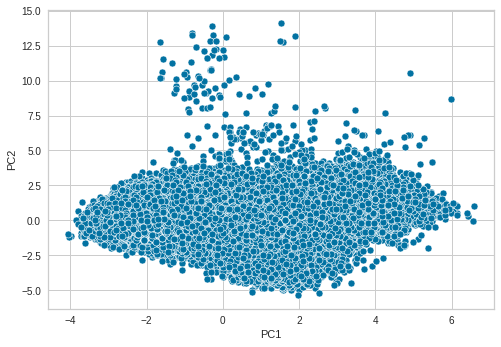

variance expliquée [0.28047516 0.1424383 ]


In [ ]:
plot_acp(spotify_acp,None)
print("variance expliquée", ratio)

Text(0.5, 0, 'Feature')

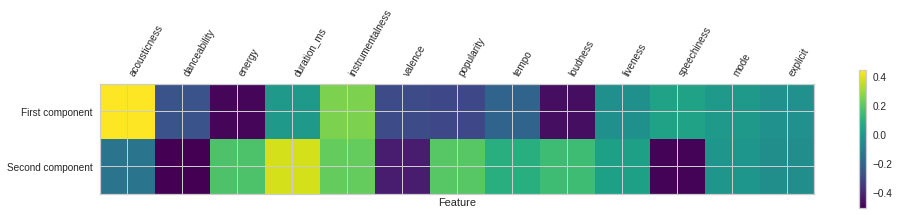

In [ ]:
plt.matshow(composant,cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(spotify_train.columns)),spotify_train.columns, rotation=60, ha='left')
plt.xlabel("Feature")

 K-means algorithm

Choosing the optimal number

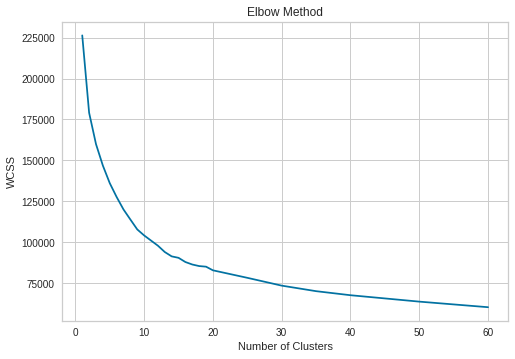

In [ ]:
wcss = []
tab =[1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,25,30,35,40,50,60]
for i in tab:
  kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
  kmeans.fit(spotify_train.sample(20000))
  wcss.append(kmeans.inertia_)
plt.plot(tab, wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.savefig('Elbow_Method.png')
plt.show()

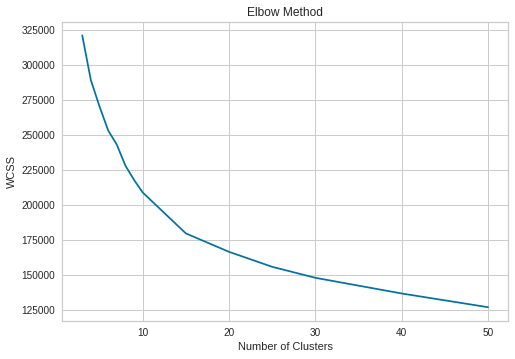

In [ ]:
wcss = []
tab =[3,4,5,6,7,8,9,10,15,20,25,30,40,50]
for i in tab:
  kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
  kmeans.fit(spotify_train.sample(40000))
  wcss.append(kmeans.inertia_)
plt.plot(tab, wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.savefig('Elbow_Method.png')
plt.show()

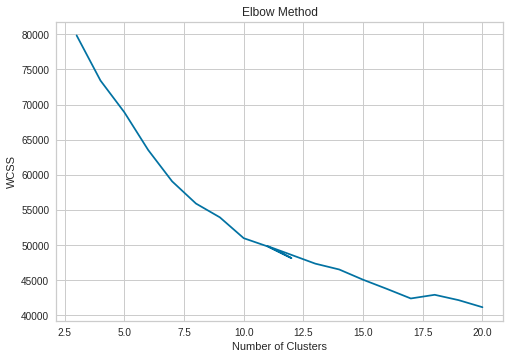

In [ ]:
wcss = []
tab =[3,4,5,6,7,8,9,10,11,12,11,13,14,15,16,17,18,19,20]
for i in tab:
  kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
  kmeans.fit(spotify_train.sample(10000))
  wcss.append(kmeans.inertia_)
plt.plot(tab, wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.savefig('Elbow_Method.png')
plt.show()

In [ ]:
s= spotify_train.sample(10000)
tab =[5,6,7,8,9,10,15,20,25,30,40,50]
for n_clusters in tab:
    clusterer = KMeans (n_clusters=n_clusters)
    clusterer_labels = clusterer.fit_predict(s)
    score = silhouette_score (s, clusterer_labels,metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 5, silhouette score is 0.15024672682564177)
For n_clusters = 6, silhouette score is 0.15698114079285974)
For n_clusters = 7, silhouette score is 0.1536940469112376)
For n_clusters = 8, silhouette score is 0.15812348912316537)
For n_clusters = 9, silhouette score is 0.15830883094152018)
For n_clusters = 10, silhouette score is 0.15483427343502656)
For n_clusters = 15, silhouette score is 0.1409153847182183)
For n_clusters = 20, silhouette score is 0.14069381380338722)
For n_clusters = 25, silhouette score is 0.1297657204306152)
For n_clusters = 30, silhouette score is 0.12559306585975086)
For n_clusters = 40, silhouette score is 0.11138408710548292)
For n_clusters = 50, silhouette score is 0.1016626292643603)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7ff38cb58a50>,
                 k=None, metric=None, model=None, timings=False)

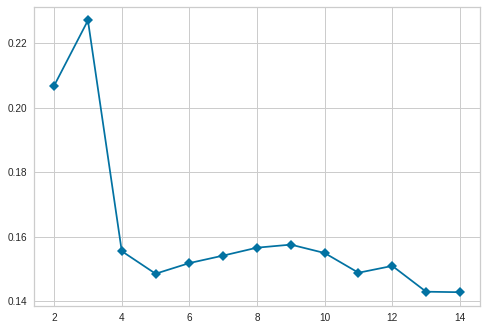

In [ ]:
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(2,15), metric='silhouette', timings=False)
visualizer.fit(spotify_train.sample(100000))

AttributeError: ignored

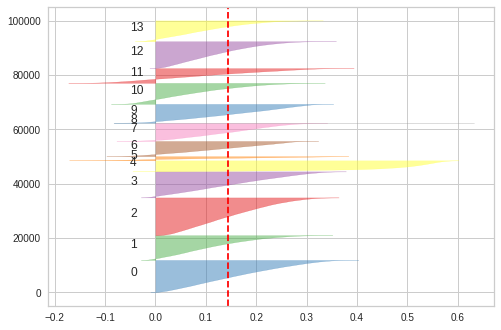

In [ ]:
visualizer_s = SilhouetteVisualizer(model,k=(2,10), metric='silhouette', timings=False)
visualizer_s.fit(spotify_train.sample(100000))
visualizer_s.show()

In [ ]:
KM = KMeans(n_clusters=6)
spotify_norm['cluster'] = KM.fit_predict(spotify_norm.iloc[:,0:12])

In [ ]:
spotify_clusters_acp, ratio,composant = acp_reduction(spotify_norm.iloc[:,0:12],2)

In [ ]:
plot_acp(spotify_clusters_acp, spotify_norm['cluster'])
print(ratio)

Clustering results